In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers torch datasets scikit-learn pandas imblearn nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import pandas as pd
import numpy as np
import re
import nltk
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
from transformers import EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

nltk.download("stopwords")
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [49]:
df = pd.read_csv("/content/drive/MyDrive/DSGP/dataset/intents_more.csv", encoding='latin-1')

In [50]:
df = df[["intent", "examples"]]
df.dropna(inplace=True)

In [51]:
df.shape

(1173, 2)

In [52]:
# Shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [53]:
print("Dataset Sample:")
print(df.head())

Dataset Sample:
             intent                                      examples
0              help                Do you understand voice input?
1           goodbye                                See you later.
2  user_preferences      I prefer short and to-the-point answers.
3      mood_excited  I just added birdwatching to my bucket list!
4     greet_welcome                          Happy to assist you!


<ipython-input-54-21866669fffa>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df["intent"], order=df["intent"].value_counts().index, palette="viridis")


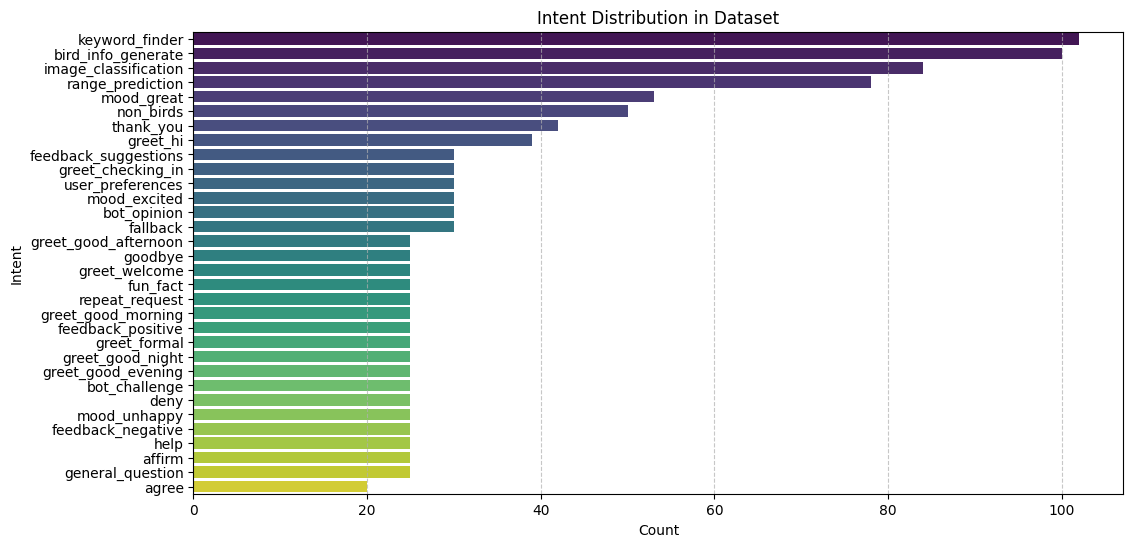

In [54]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

plt.figure(figsize=(12, 6))
sns.countplot(y=df["intent"], order=df["intent"].value_counts().index, palette="viridis")
plt.xlabel("Count")
plt.ylabel("Intent")
plt.title("Intent Distribution in Dataset")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

## Convert intents into numerical values

In [55]:
label_encoder = LabelEncoder()
df["intent"] = label_encoder.fit_transform(df["intent"])

### Label Mapping

In [56]:
# Store Label Mapping for Future Use
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'affirm': 0, 'agree': 1, 'bird_info_generate': 2, 'bot_challenge': 3, 'bot_opinion': 4, 'deny': 5, 'fallback': 6, 'feedback_negative': 7, 'feedback_positive': 8, 'feedback_suggestions': 9, 'fun_fact': 10, 'general_question': 11, 'goodbye': 12, 'greet_checking_in': 13, 'greet_formal': 14, 'greet_good_afternoon': 15, 'greet_good_evening': 16, 'greet_good_morning': 17, 'greet_good_night': 18, 'greet_hi': 19, 'greet_welcome': 20, 'help': 21, 'image_classification': 22, 'keyword_finder': 23, 'mood_excited': 24, 'mood_great': 25, 'mood_unhappy': 26, 'non_birds': 27, 'range_prediction': 28, 'repeat_request': 29, 'thank_you': 30, 'user_preferences': 31}


## Random Oversampling

In [57]:
X = df["examples"]
y = df["intent"]

oversample = RandomOverSampler(sampling_strategy="auto", random_state=42)
X_resampled, y_resampled = oversample.fit_resample(X.values.reshape(-1, 1), y)

In [58]:
df_balanced = pd.DataFrame({"examples": X_resampled.flatten(), "intent": y_resampled})
print("Balanced Class Distribution:\n", df_balanced["intent"].value_counts())

Balanced Class Distribution:
 intent
8     102
3     102
29    102
6     102
20    102
15    102
1     102
9     102
10    102
25    102
17    102
12    102
14    102
18    102
16    102
19    102
11    102
13    102
31    102
24    102
5     102
26    102
27    102
30    102
7     102
2     102
22    102
28    102
21    102
0     102
23    102
4     102
Name: count, dtype: int64


## Dataset Preprocessing

In [59]:
stop_words = set(stopwords.words("english"))

In [60]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

In [61]:
# Apply text preprocessing
df_balanced["examples"] = df_balanced["examples"].apply(preprocess_text)

print("Text Preprocessing Complete!")
print(df_balanced.head())

Text Preprocessing Complete!
                                      examples  intent
0                              better expected       8
1                                        human       3
2                              keep great work       8
3  saw bird gliding air chirping sound guesses      23
4                                      exactly       0


## Split Dataset

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced["examples"], df_balanced["intent"], test_size=0.2, random_state=42
)

### Load BERT Tokenizer

In [63]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, return_tensors="pt")

## Create Dataset Objects

In [64]:
class IntentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Convert Intent Labels to Numeric
train_labels = y_train.tolist()
test_labels = y_test.tolist()

# Create Dataset Objects
train_dataset = IntentDataset(train_encodings, train_labels)
test_dataset = IntentDataset(test_encodings, test_labels)


## Build BERT model

In [65]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_mapping)
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [66]:
training_args = TrainingArguments(
    output_dir="./bert_intent_model",
    num_train_epochs=15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [67]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted", zero_division=1
    )
    acc = accuracy_score(labels, preds)

    print(f"Train Accuracy: {acc}")

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

In [68]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,3.208100,3.011652,0.284839,0.239117,0.568305,0.284839
2,1.918900,1.678890,0.655436,0.651715,0.740128,0.655436
3,0.645800,0.582340,0.885145,0.885655,0.897426,0.885145
4,0.243900,0.303120,0.924962,0.926735,0.935555,0.924962
5,0.095300,0.248458,0.944870,0.944681,0.949003,0.944870
6,0.046500,0.214117,0.947933,0.947511,0.949529,0.947933
7,0.112100,0.254399,0.943338,0.943122,0.946155,0.943338
8,0.125300,0.221860,0.947933,0.947699,0.950718,0.947933
9,0.114600,0.225536,0.947933,0.947951,0.950656,0.947933


Train Accuracy: 0.28483920367534454
Train Accuracy: 0.655436447166922
Train Accuracy: 0.885145482388974
Train Accuracy: 0.9249617151607963
Train Accuracy: 0.9448698315467075
Train Accuracy: 0.9479326186830015
Train Accuracy: 0.9433384379785605
Train Accuracy: 0.9479326186830015
Train Accuracy: 0.9479326186830015


TrainOutput(global_step=1476, training_loss=0.8733324244880902, metrics={'train_runtime': 248.5273, 'train_samples_per_second': 157.588, 'train_steps_per_second': 9.898, 'total_flos': 253661628628800.0, 'train_loss': 0.8733324244880902, 'epoch': 9.0})

In [69]:
eval_results = trainer.evaluate()
print("Evaluation Results:")
print(f"Accuracy: {eval_results['eval_accuracy']}")
print(f"Precision: {eval_results['eval_precision']}")
print(f"Recall: {eval_results['eval_recall']}")
print(f"F1 Score: {eval_results['eval_f1']}")

Train Accuracy: 0.9479326186830015
Evaluation Results:
Accuracy: 0.9479326186830015
Precision: 0.9495291252280013
Recall: 0.9479326186830015
F1 Score: 0.9475111975202356


In [70]:
from sklearn.metrics import classification_report

y_pred_logits = trainer.predict(test_dataset).predictions
y_pred = y_pred_logits.argmax(-1)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_mapping.keys()))

Train Accuracy: 0.9479326186830015
Classification Report:
                      precision    recall  f1-score   support

              affirm       0.89      0.94      0.92        18
               agree       0.90      0.95      0.93        20
  bird_info_generate       0.92      0.96      0.94        24
       bot_challenge       1.00      0.95      0.98        22
         bot_opinion       0.89      1.00      0.94        17
                deny       1.00      0.95      0.98        21
            fallback       0.88      0.82      0.85        17
   feedback_negative       0.95      0.95      0.95        21
   feedback_positive       0.94      0.80      0.86        20
feedback_suggestions       0.95      0.95      0.95        21
            fun_fact       1.00      0.95      0.98        22
    general_question       0.88      0.88      0.88         8
             goodbye       0.81      1.00      0.89        17
   greet_checking_in       0.86      1.00      0.93        19
        gre

Train Accuracy: 0.9479326186830015


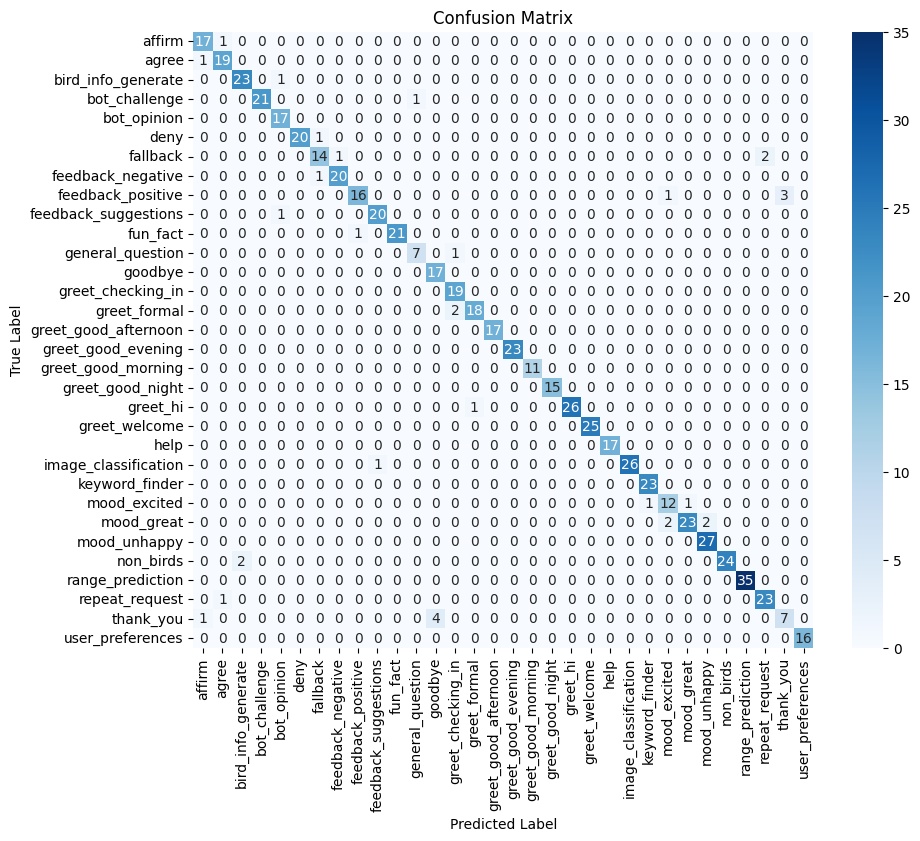

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred_logits = trainer.predict(test_dataset).predictions
y_pred = y_pred_logits.argmax(-1)

conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


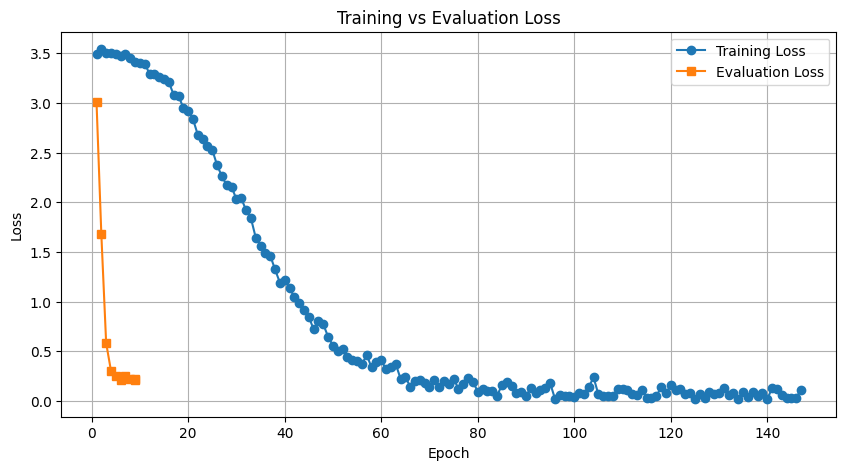

In [72]:
# Extract training and evaluation loss history
train_losses = []
eval_losses = []
epochs = []

for log in trainer.state.log_history:
    if "loss" in log:
        train_losses.append(log["loss"])
    if "eval_loss" in log:
        eval_losses.append(log["eval_loss"])
        epochs.append(log["epoch"])

# Plot Training vs. Evaluation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker='o')
plt.plot(epochs, eval_losses, label="Evaluation Loss", marker='s')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Evaluation Loss")
plt.legend()
plt.grid()
plt.show()

## Hyperparameter Tuning

In [78]:
training_args = TrainingArguments(
    output_dir="./bert_intent_model",
    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=300,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    learning_rate=2e-5,
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [79]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)


In [80]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.048700,0.208558,0.943338,0.943820,0.946314,0.943338
2,0.066200,0.214598,0.949464,0.949071,0.951806,0.949464
3,0.060000,0.211883,0.944870,0.944869,0.947832,0.944870
4,0.048300,0.201588,0.947933,0.948200,0.951326,0.947933


Train Accuracy: 0.9433384379785605
Train Accuracy: 0.9494640122511485
Train Accuracy: 0.9448698315467075
Train Accuracy: 0.9479326186830015


TrainOutput(global_step=328, training_loss=0.059776723112274964, metrics={'train_runtime': 87.5225, 'train_samples_per_second': 298.323, 'train_steps_per_second': 9.369, 'total_flos': 112738501612800.0, 'train_loss': 0.059776723112274964, 'epoch': 4.0})

In [81]:
eval_results = trainer.evaluate()
print("Updated Evaluation Results:")
print(f"Accuracy: {eval_results['eval_accuracy']}")
print(f"Precision: {eval_results['eval_precision']}")
print(f"Recall: {eval_results['eval_recall']}")
print(f"F1 Score: {eval_results['eval_f1']}")


Train Accuracy: 0.9494640122511485
Updated Evaluation Results:
Accuracy: 0.9494640122511485
Precision: 0.9518057228005813
Recall: 0.9494640122511485
F1 Score: 0.9490708251276152


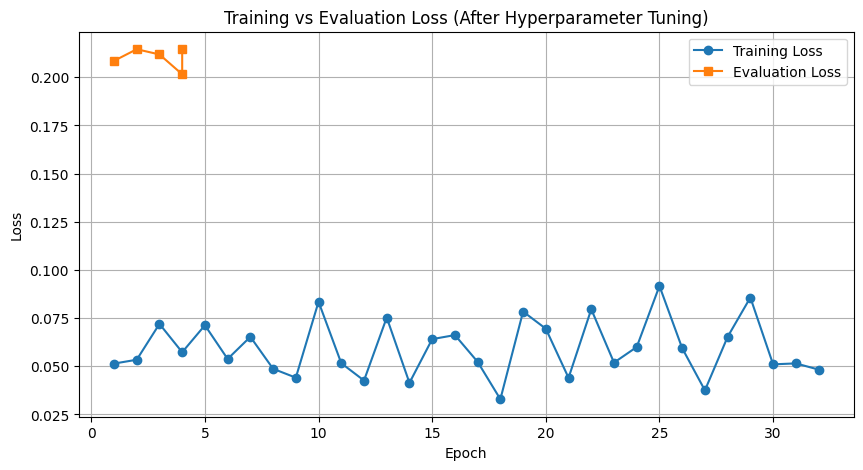

In [82]:
import matplotlib.pyplot as plt

train_losses = []
eval_losses = []
epochs = []

for log in trainer.state.log_history:
    if "loss" in log:
        train_losses.append(log["loss"])
    if "eval_loss" in log:
        eval_losses.append(log["eval_loss"])
        epochs.append(log["epoch"])  # Log epoch for evaluation points

# Plot Training vs. Evaluation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker='o')
plt.plot(epochs, eval_losses, label="Evaluation Loss", marker='s')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Evaluation Loss (After Hyperparameter Tuning)")
plt.legend()
plt.grid()
plt.show()


In [83]:
model_save_path = "/content/drive/MyDrive/DSGP/models/BERT_model_4_finetuned"

trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Fine-tuned model saved at: {model_save_path}")


Fine-tuned model saved at: /content/drive/MyDrive/DSGP/models/BERT_model_4_finetuned
